In [1]:
# Imports
import sys
sys.path.append("Program")

import datetime as dt
from fundamentals import *
from helper_functions import get_current_date, generate_end_dates, stock_market, merge_stocks
import pandas as pd
from plot import *
from stock_screener import EM_rating, stoploss_target
from technicals import *

In [2]:
# Start of the program
start = dt.datetime.now()

# Initial setup
current_date = get_current_date(start)

[*********************100%%**********************]  1 of 1 completed


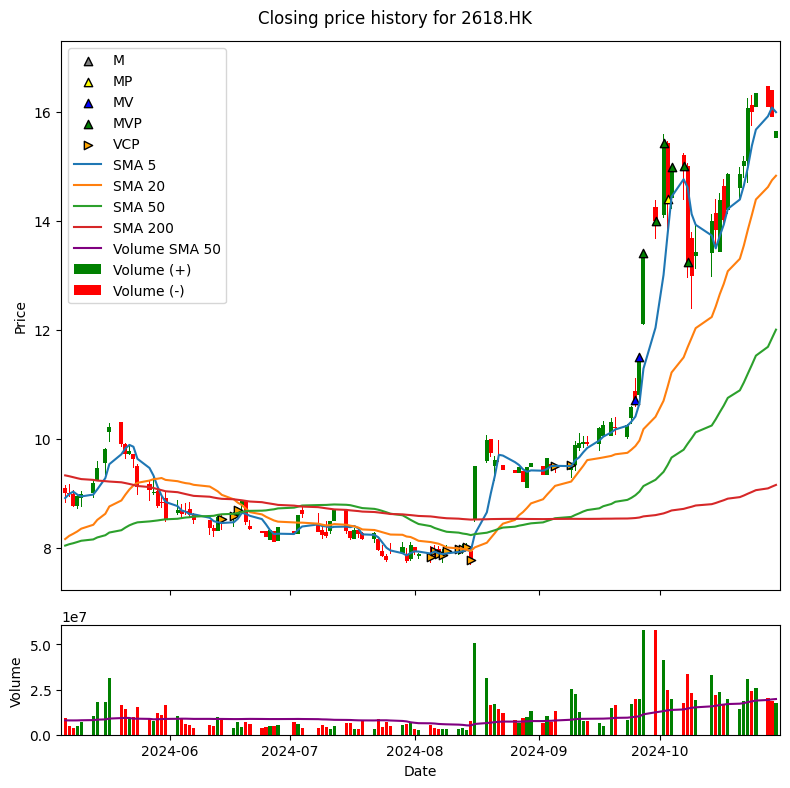

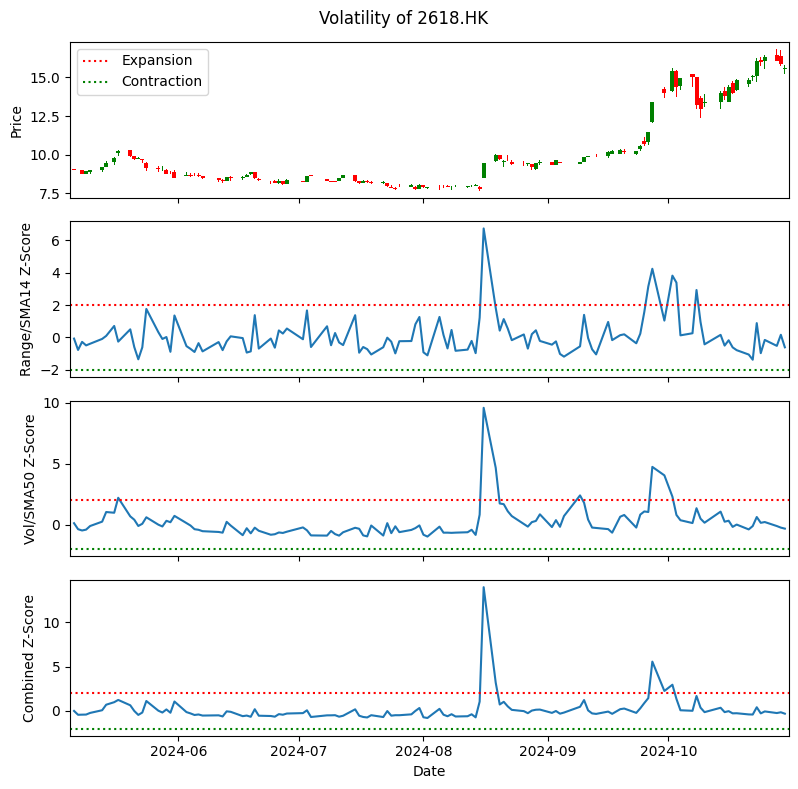

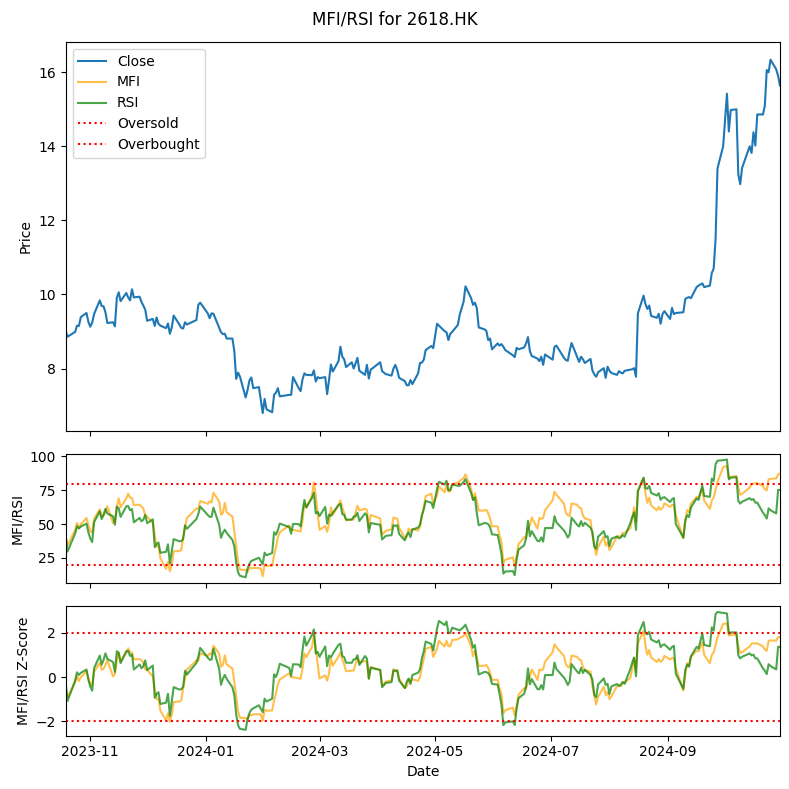

[*********************100%%**********************]  1 of 1 completed


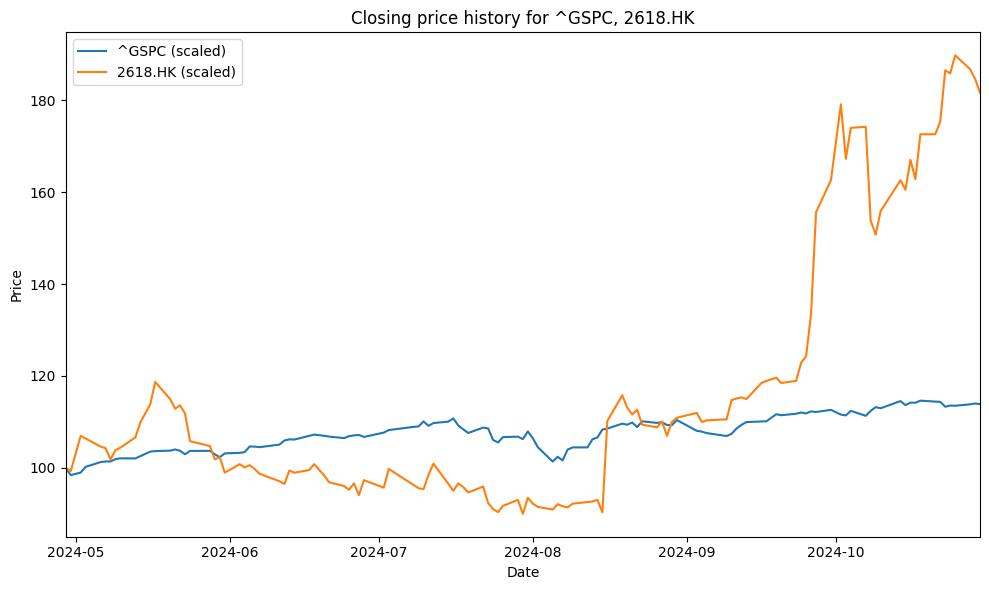

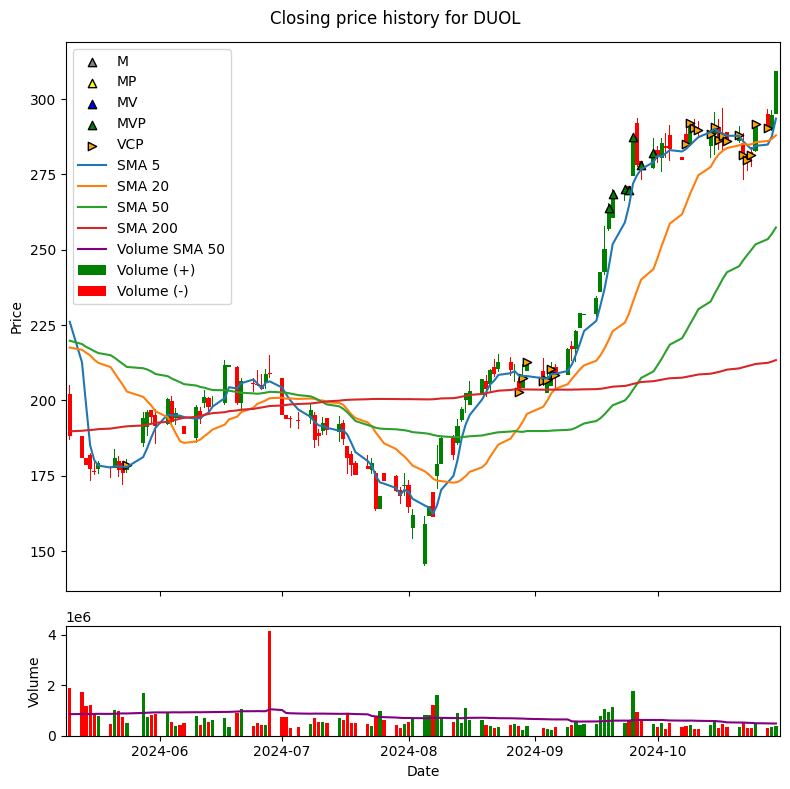

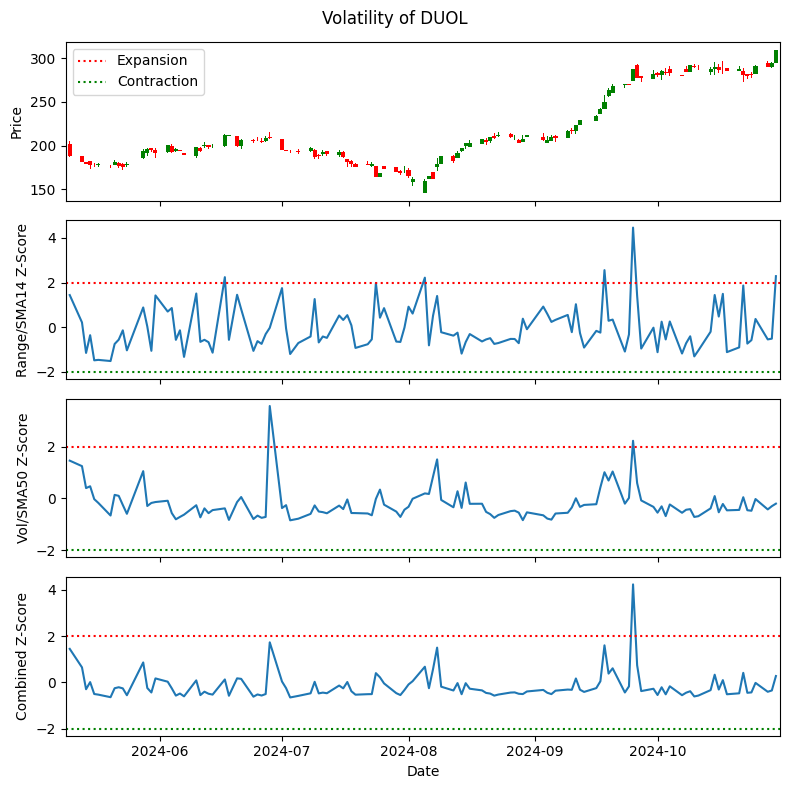

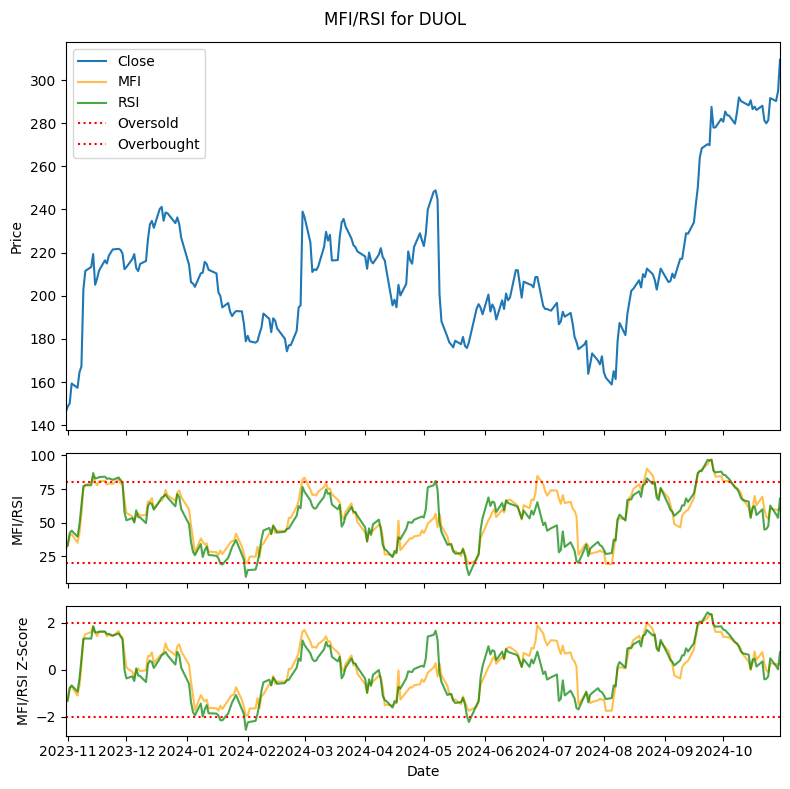

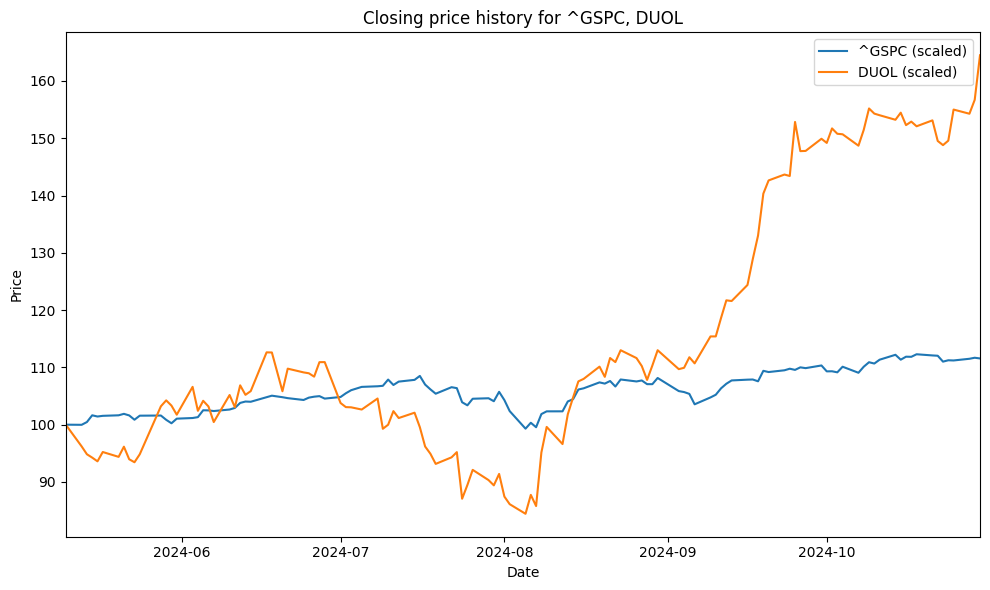

[*********************100%%**********************]  1 of 1 completed


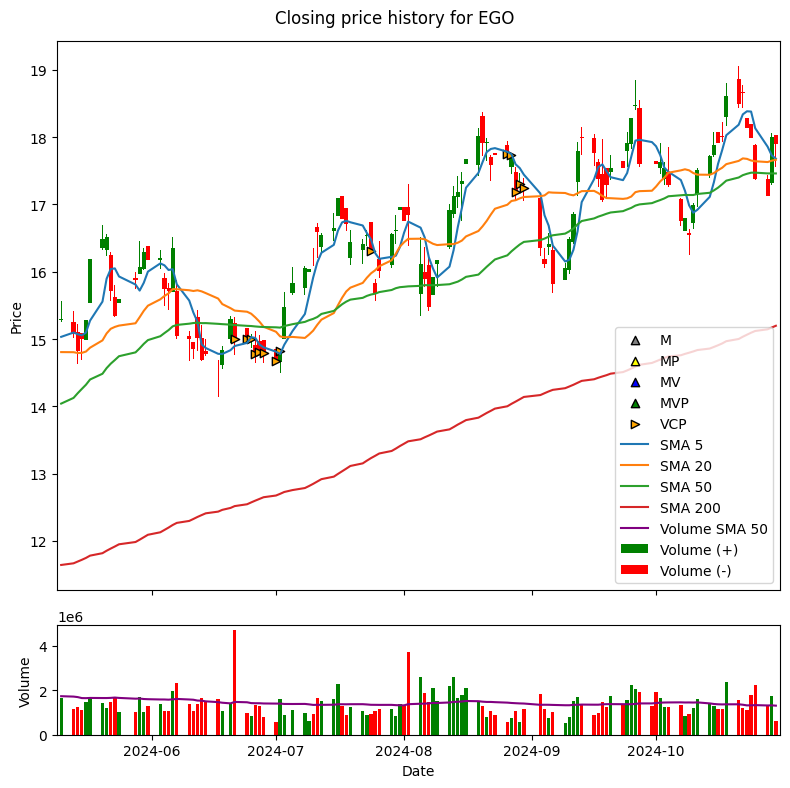

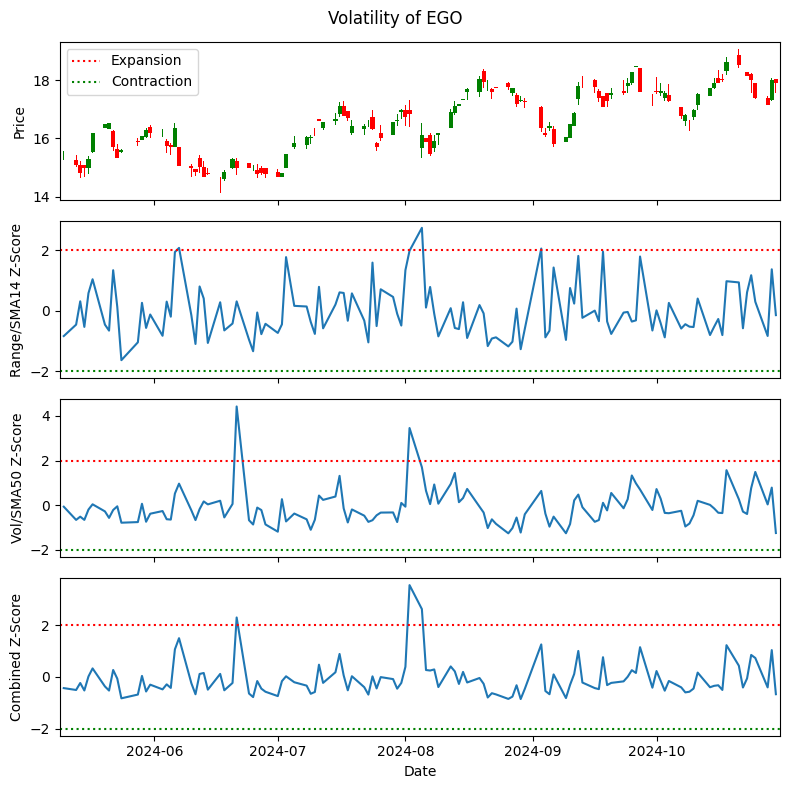

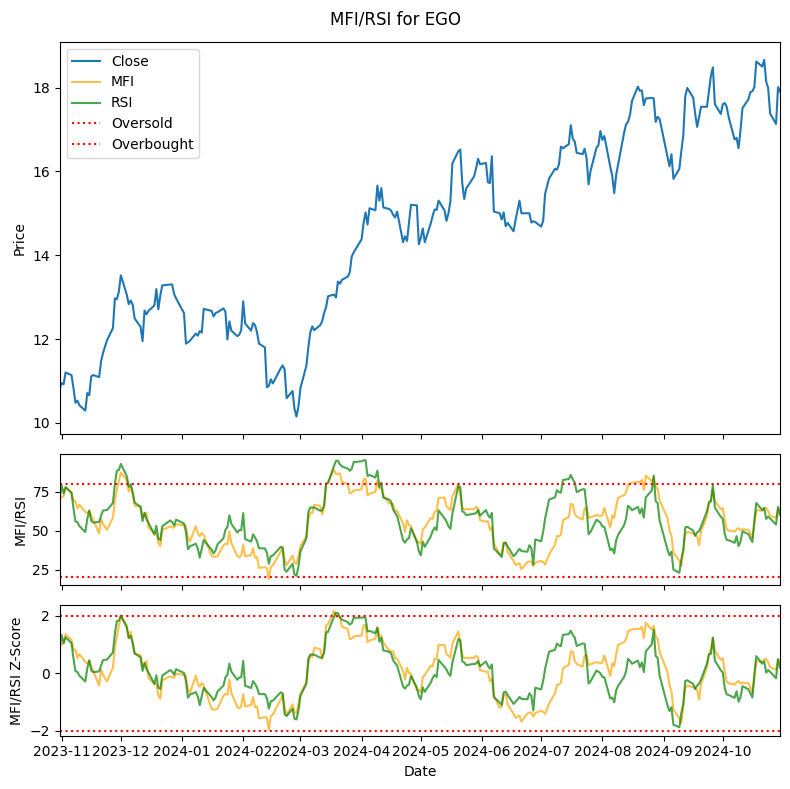

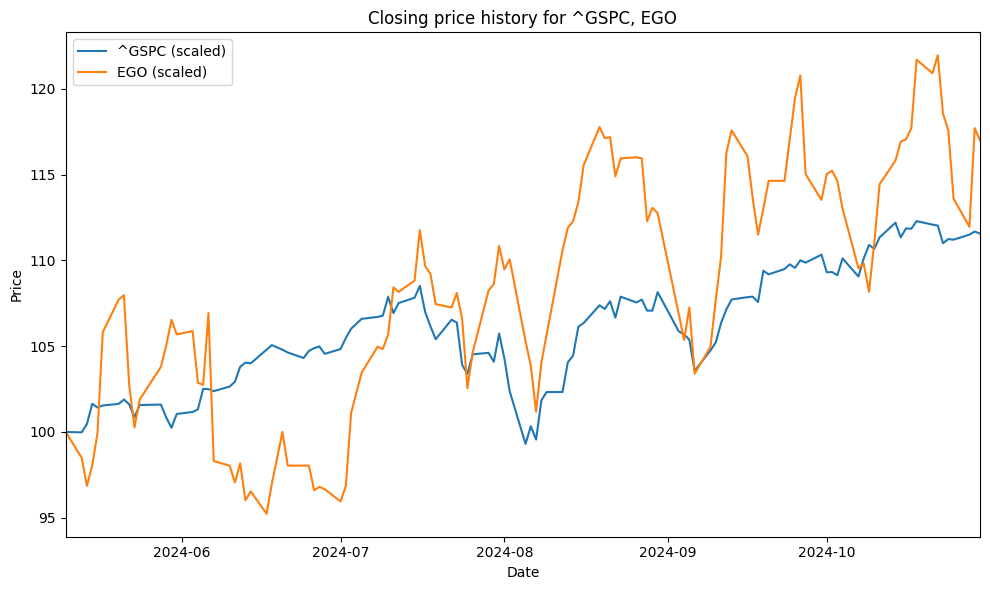

[*********************100%%**********************]  1 of 1 completed


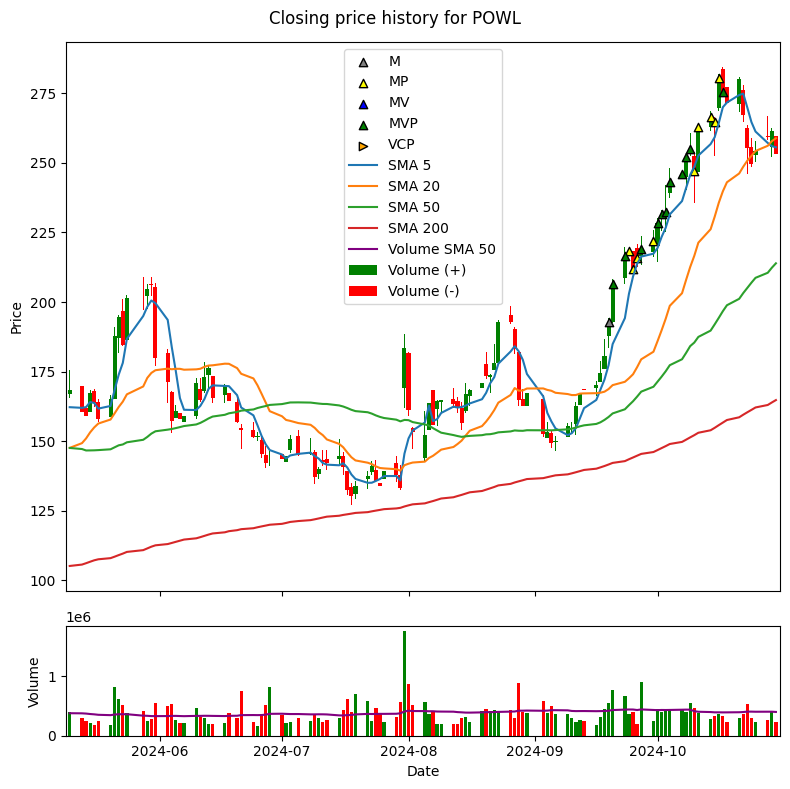

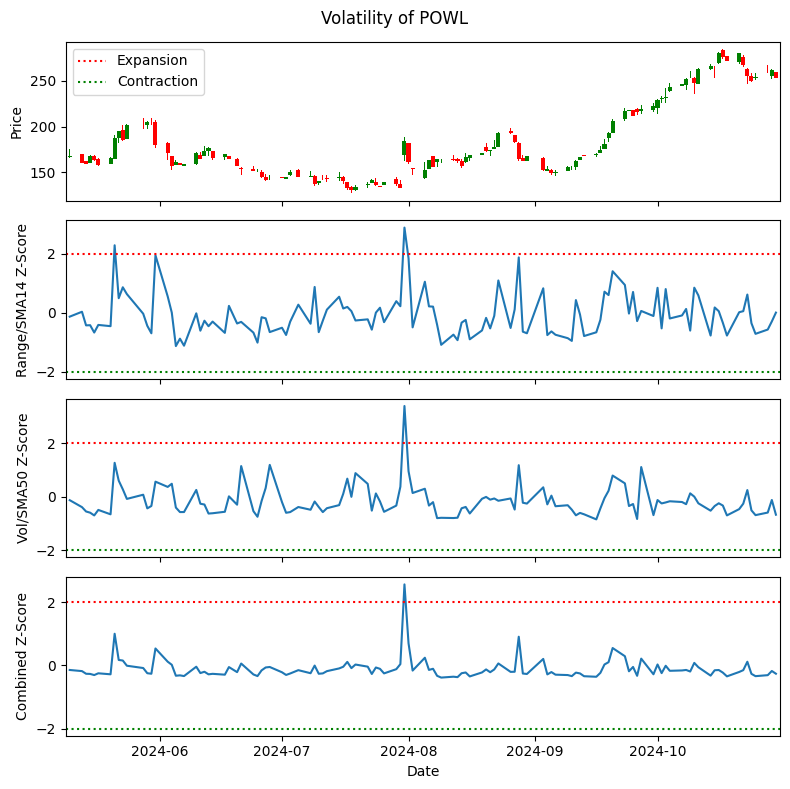

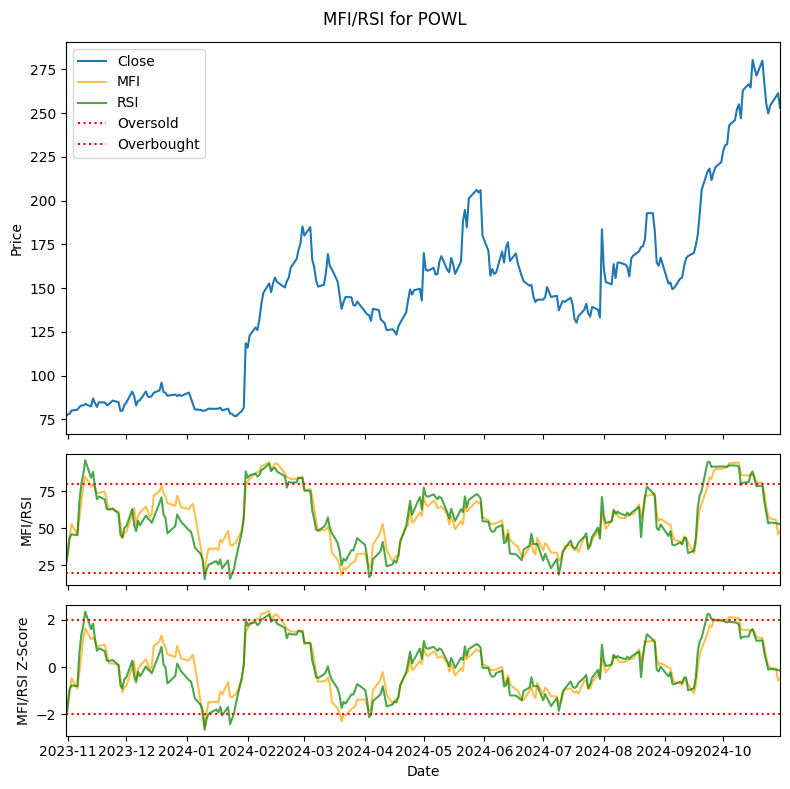

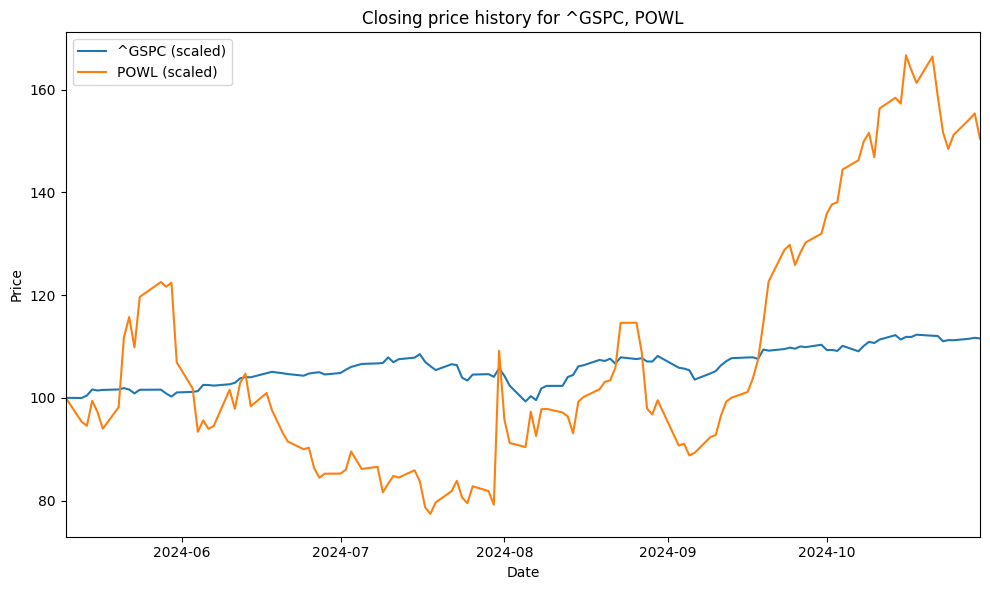

In [27]:
# Choose the stocks
stocks = ["2618.HK", "DUOL", "EGO", "POWL"]
for stock in stocks:
    df = get_df(stock, current_date)
    plot_close(stock, df)
    plot_volatility(stock, df, 252)
    plot_MFI_RSI(stock, df, 252)
    plot_stocks(["^GSPC", stock], current_date)

In [24]:
# Get the stop loss and target price of a stock
stock = "CORZ"
df = get_df(stock, current_date)
current_close = df["Close"].iloc[-1]
stoploss, stoploss_pct, target, target_pct = stoploss_target(stock, 12.5, "2024-10-07")
print(f"Plan for {stock}.")
print(f"Current close: {round(current_close, 2)}.")
print(f"SL {stoploss} ({stoploss_pct}%) TP {target} ({target_pct}%)")

Plan for CORZ.
Current close: 14.01.
SL 11.5 (8.0%) TP 14.5 (16.0%)


In [23]:
# Calculate the new stop loss
price_avg = 12.906
stoploss_2r = price_avg * (1 - stoploss_pct / 100)
stoploss_2r = round(stoploss_2r, 2)
stoploss_1r = price_avg * (1 - stoploss_pct / 100 / 2)
stoploss_1r = round(stoploss_1r, 2)
stoploss_0r = price_avg
stoploss_0r = round(stoploss_0r, 2)
print(f"SL {stoploss_2r} ({stoploss_pct}%)")
print(f"SL {stoploss_1r} ({stoploss_pct / 2}%)")
print(f"SL {stoploss_0r} (0.0%)")

SL 11.87 (8.0%)
SL 12.39 (4.0%)
SL 12.91 (0.0%)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


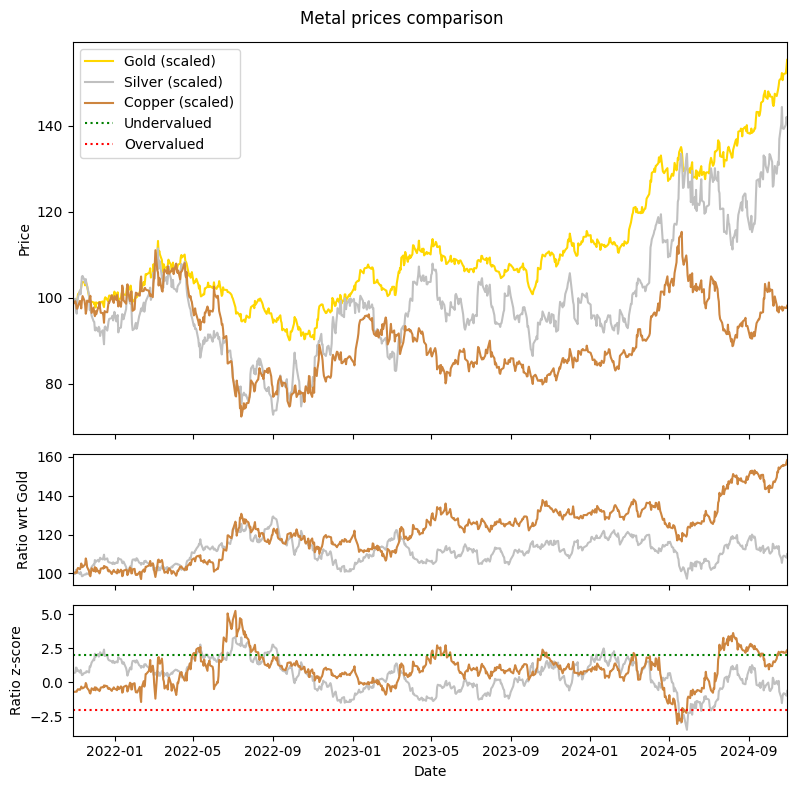

In [25]:
show = 252 * 3
stocks = ["GC=F", "SI=F", "HG=F"]
metal_df = merge_stocks(stocks, current_date)
metal_df["Gold/Silver Ratio"] = metal_df["Close (GC=F)"] / metal_df["Close (SI=F)"]
metal_df["Gold/Copper Ratio"] = metal_df["Close (GC=F)"] / metal_df["Close (HG=F)"]
metal_df = calculate_ZScore(metal_df, ["Gold/Silver Ratio", "Gold/Copper Ratio"], 252)

# Restrict the dataframe
metal_df = metal_df[- show:]

# Create a figure with three subplots, one for the metal prices, one for the ratios, one for the ratios z-score
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8), gridspec_kw={"height_ratios": [3, 1, 1]}, sharex=True)

# Plot the metal prices on the first subplot
close_goldfirst = metal_df["Close (GC=F)"].iloc[0]
close_silverfirst = metal_df["Close (SI=F)"].iloc[0]
close_copperfirst = metal_df["Close (HG=F)"].iloc[0]
ax1.plot(100 / close_goldfirst * metal_df["Close (GC=F)"], label="Gold (scaled)", color="gold")
ax1.plot(100 / close_silverfirst * metal_df["Close (SI=F)"], label="Silver (scaled)", color="silver")
ax1.plot(100 / close_copperfirst * metal_df["Close (HG=F)"], label="Copper (scaled)", color="peru")

# Set the label of the first subplot
ax1.set_ylabel("Price")

# Set the x limit of the first subplot
ax1.set_xlim(metal_df.index[0], metal_df.index[-1])

# Plot the ratios on the second subplot
goldsilver_ratio_first = metal_df["Gold/Silver Ratio"].iloc[0]
goldcopper_ratio_first = metal_df["Gold/Copper Ratio"].iloc[0]
ax2.plot(100 / goldsilver_ratio_first * metal_df["Gold/Silver Ratio"], color="silver")
ax2.plot(100 / goldcopper_ratio_first * metal_df["Gold/Copper Ratio"], color="peru")

# Set the y label of the second subplot
ax2.set_ylabel("Ratio wrt Gold")

# Plot the ratios z-score on the third subplot
ax3.plot(metal_df["Gold/Silver Ratio Z-Score"], color="silver")
ax3.plot(metal_df["Gold/Copper Ratio Z-Score"], color="peru")
ax3.axhline(y=2, linestyle="dotted", label="Undervalued", color="green")
ax3.axhline(y=-2, linestyle="dotted", label="Overvalued", color="red")

# Set the y label of the third subplot
ax3.set_ylabel("Ratio z-score")

# Set the x label
plt.xlabel("Date")

# Set the title
plt.suptitle(f"Metal prices comparison")

# Combine the legends and place them at the top subplot
handles, labels = ax1.get_legend_handles_labels()
handles += ax3.get_legend_handles_labels()[0]
labels += ax3.get_legend_handles_labels()[1]
ax1.legend(handles, labels)

# Adjust the spacing between subplots
plt.tight_layout()

# Save the plot
plt.savefig("Result/Figure/metalcompare.png", dpi=300)    

# Show the plot
plt.show()

[*********************100%%**********************]  1 of 1 completed


                    Open          High           Low         Close  \
Date                                                                 
2017-07-27  27002.699219  27169.150391  26962.029297  27131.169922   
2018-01-09  30933.509766  31056.699219  30852.429688  31011.410156   
2018-01-10  31009.240234  31267.570312  30928.580078  31073.720703   
2018-01-16  31423.619141  31904.750000  31423.619141  31904.750000   
2018-01-17  31825.519531  31983.410156  31642.269531  31983.410156   
2018-01-18  32148.449219  32233.810547  31869.699219  32121.939453   
2018-01-19  32142.160156  32254.890625  31986.000000  32254.890625   
2018-01-22  32276.960938  32417.230469  32046.839844  32393.410156   
2018-01-23  32606.140625  32930.699219  32554.230469  32930.699219   
2018-01-24  32907.230469  33018.710938  32728.509766  32958.691406   
2024-09-30  21175.410156  21488.750000  20789.929688  21133.679688   
2024-10-02  21289.599609  22667.740234  21289.599609  22443.730469   
2024-10-24  20576.05

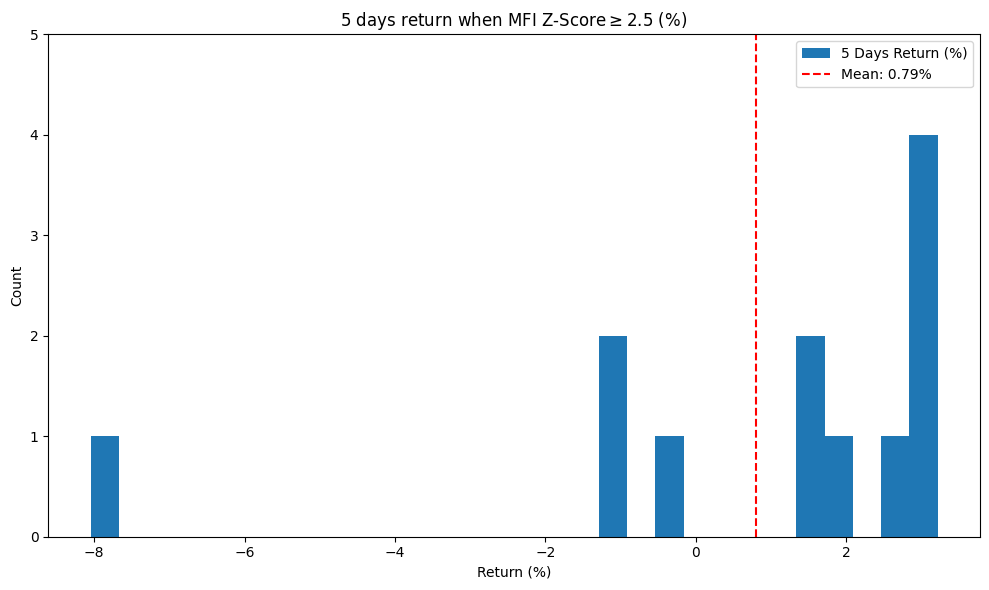

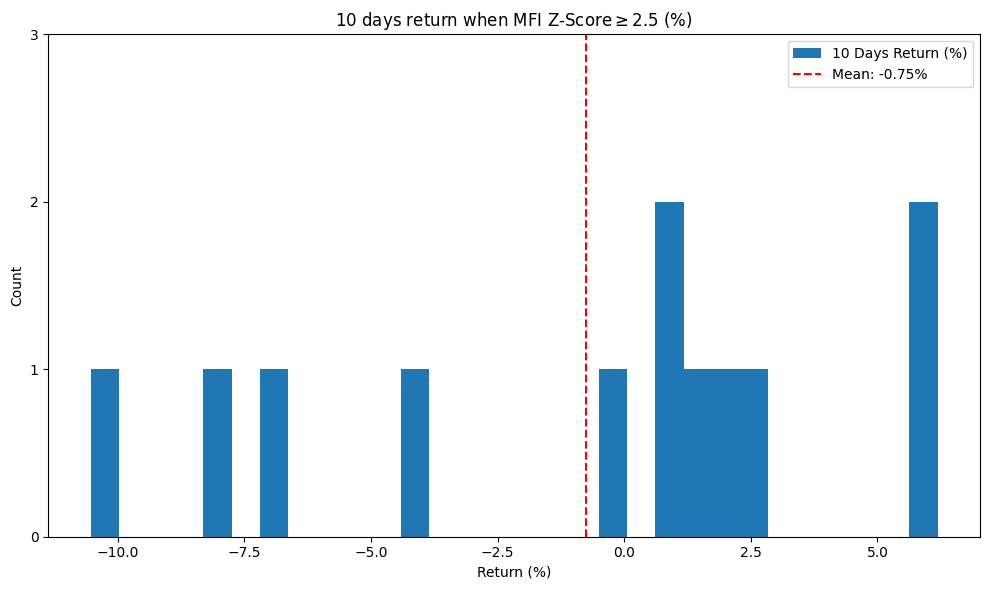

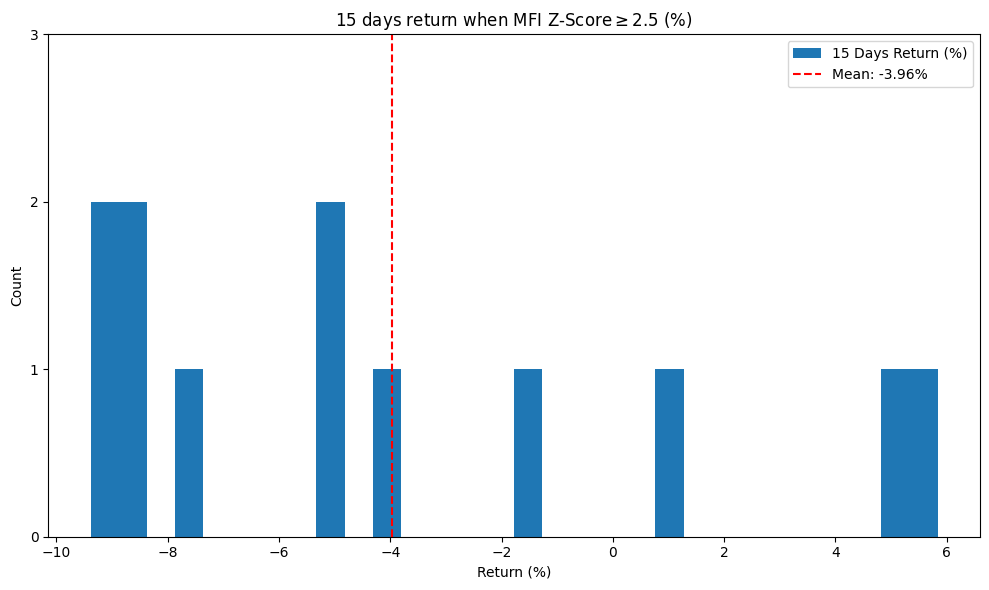

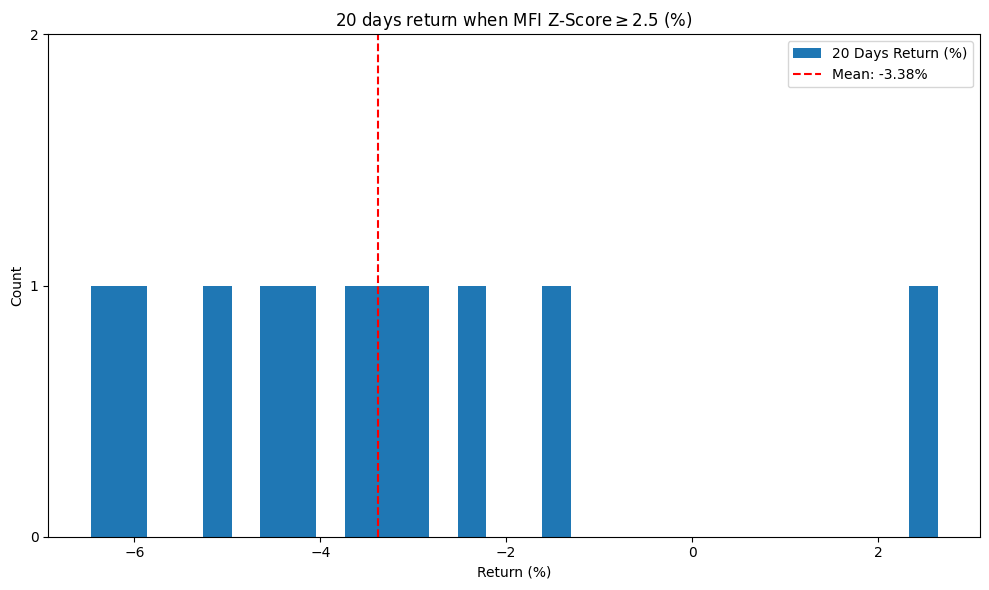

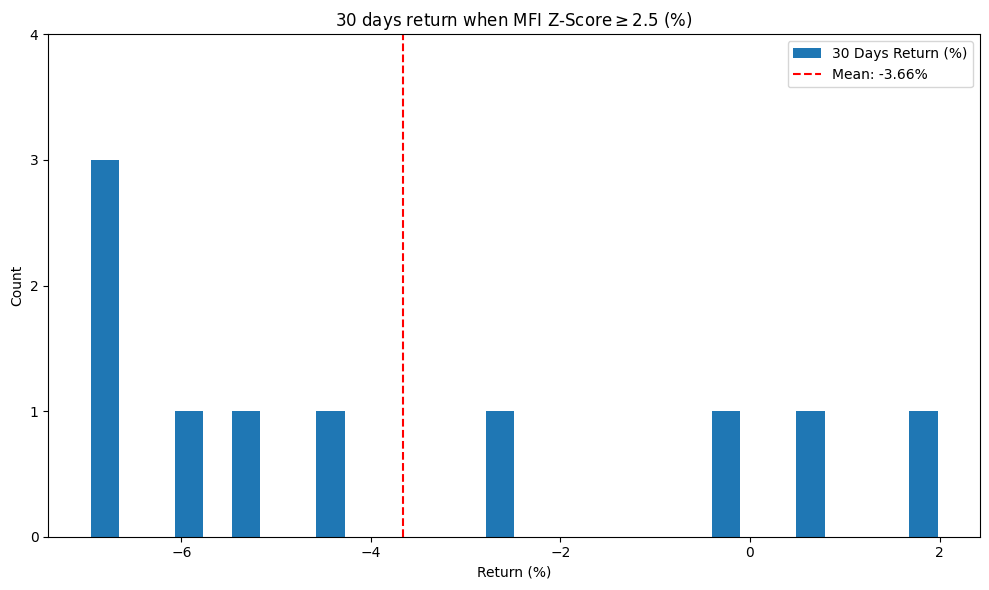

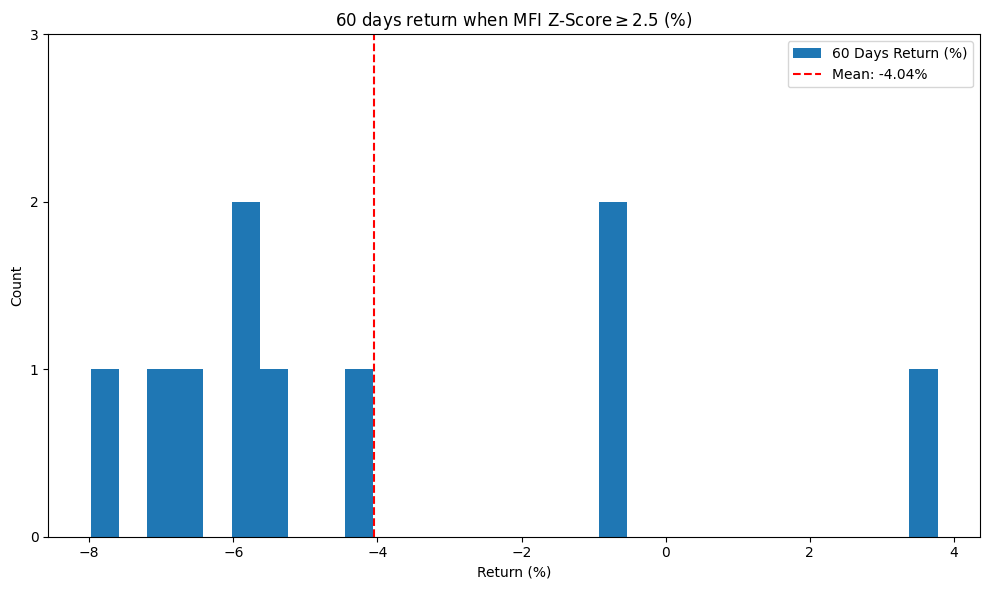

In [26]:
# Choose the stock
stock = "^HSI"

# Get the price data of the stock
df = get_df(stock, current_date)

# Add indicators
df = add_indicator(df)
df = calculate_ZScore(df, ["MFI", "RSI"], period=252*15)

# Save the data of the index to a .csv file
filename = f"Price data/{stock}_{current_date}.csv"
df.to_csv(filename)

periods = [5, 10, 15, 20, 30, 60]
for period in periods:
    df[f"Close {period} Later"] = df["Close"].shift(- period)
    df[f"{period} Days Return (%)"] = ((df[f"Close {period} Later"] / df["Close"]) - 1) * 100

# Filter for MFI/RSI Z-Score >= 2.5
df_MFIRSI_filter = df[(df["MFI Z-Score"] >= 2.5)]
print(df_MFIRSI_filter)

# Plot histogram
for period in periods:
    # Create a figure
    plt.figure(figsize=(10, 6))

    # Plot the histogram
    plt.hist(df_MFIRSI_filter[f"{period} Days Return (%)"].dropna(), bins=30, label=f'{period} Days Return (%)')

    # Calculate the mean
    mean = df_MFIRSI_filter.loc[:, f"{period} Days Return (%)"].mean()

    # Draw a vertical line at the mean
    plt.axvline(mean, color="red", linestyle="dashed", linewidth=1.5, label=f"Mean: {mean:.2f}%")

    # Set the y-axis ticks to integers
    y_ticks = np.arange(0, plt.ylim()[1] + 1, 1)
    plt.yticks(y_ticks)

    # Set the labels
    plt.xlabel("Return (%)")
    plt.ylabel("Count")

    # Set the title
    plt.title(rf"{period} days return when MFI Z-Score$\geq 2.5$ (%)")

    # Set the legend
    plt.legend()

    # Adjust the spacing
    plt.tight_layout()

    # Save the plot
    plt.savefig(f"Result/Figure/{period}returnMFIZgeq2.5.png", dpi=300)

    # Show the plot
    plt.show()